<a href="https://colab.research.google.com/github/st-reid/temp/blob/main/Unsupervised_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages

In [1]:
!pip install geopandas
!pip install mpld3

In [2]:
#import packages
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
from datetime import timedelta

from datetime import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

## models
from sklearn.cluster import KMeans

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import plotly.express as px

In [3]:
#import data

ufo_df = pd.read_csv ('https://raw.githubusercontent.com/st-reid/temp/main/UFO-1149.csv')

ufo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  float64
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80318 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  float64
 10  longitude             80332 non-null  float64
dtypes: float64(3), object(8)
memory usage: 6.7+ MB


In [4]:
ufo_df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8831,-97.9411
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.3842,-98.5811
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2000,-2.9167
3,10/10/1956 21:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783,-96.6458
4,10/10/1960 20:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4181,-157.8036


In [5]:
#take out spaces from column names

ufo_df1= ufo_df.copy()
### format columns of train data

ufo_df1.columns = [col.replace(' ','_') for col in ufo_df1]  

ufo_df1.head()



,datetime,city,state,country,shape,duration_(seconds),duration_(hours/min),comments,date_posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8831,-97.9411
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.3842,-98.5811
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2000,-2.9167
3,10/10/1956 21:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783,-96.6458
4,10/10/1960 20:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4181,-157.8036


In [6]:
## format date columns to dates

ufo_df1['datetime'] = ufo_df1['datetime'].str.replace('24:00', '0:00')
ufo_df1['datetime']=ufo_df1['datetime'].astype('datetime64[ns]')

ufo_df1['date_posted']=ufo_df1['date_posted'].astype('datetime64[ns]')

ufo_df1.head()

,datetime,city,state,country,shape,duration_(seconds),duration_(hours/min),comments,date_posted,latitude,longitude
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.8831,-97.9411
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.3842,-98.5811
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.2000,-2.9167
3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.9783,-96.6458
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.4181,-157.8036


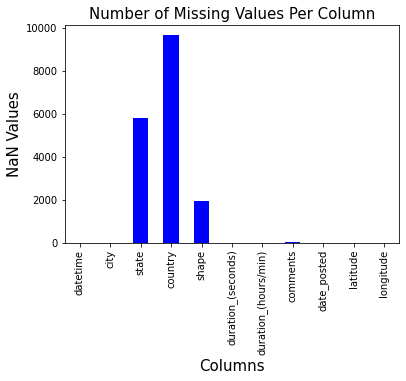

In [7]:
## check Nan values

# plot missing data for the test dats:
ufo_df1.isnull().sum().plot(kind='bar', color='blue')
# Add a title and show the plot.
plt.title('Number of Missing Values Per Column', fontsize=15)
# Create tick mark labels on the Y axis and rotate them.
plt.xticks(rotation = 90)
# Create X axis label.
plt.xlabel("Columns", fontsize=15)
# Create Y axis label.
plt.ylabel("NaN Values",fontsize=15 );


In [8]:
## replace missing value with blanks

ufo_df2 = ufo_df1.copy()

ufo_df2['state'] = ufo_df2['state'].fillna('')

ufo_df2['country'] = ufo_df2['country'].fillna('')

ufo_df2['shape'] = ufo_df2['shape'].fillna('')


ufo_df2.head(5)

,datetime,city,state,country,shape,duration_(seconds),duration_(hours/min),comments,date_posted,latitude,longitude
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.8831,-97.9411
1,1949-10-10 21:00:00,lackland afb,tx,,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.3842,-98.5811
2,1955-10-10 17:00:00,chester (uk/england),,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.2000,-2.9167
3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.9783,-96.6458
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.4181,-157.8036


us    81.056117
ca     3.734502
gb     2.371409
au     0.669721
de     0.130708
Name: country, dtype: float64


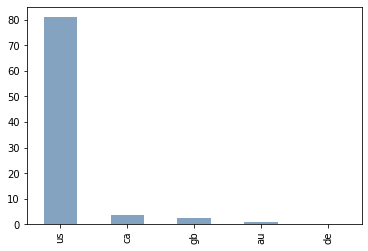

In [9]:
## find the countries represented

counts = ufo_df1['country'].value_counts()

total = len(ufo_df1['country'])

frequency = counts/total*100

frequency.plot(kind = 'bar',color=(0.2, 0.4, 0.6, 0.6))

print(frequency)

### Calculate the number of clusters for Kmeans

In [10]:
## use the co-ords only
cols = ['datetime','city','state','country','shape','duration_(seconds)','duration_(hours/min)','comments','date_posted']

ufo_cords = ufo_df2.drop(cols, inplace=False, axis=1)

ufo_cords.head(5)

,latitude,longitude
0,29.8831,-97.9411
1,29.3842,-98.5811
2,53.2000,-2.9167
3,28.9783,-96.6458
4,21.4181,-157.8036


Text(0, 0.5, 'Latitude')

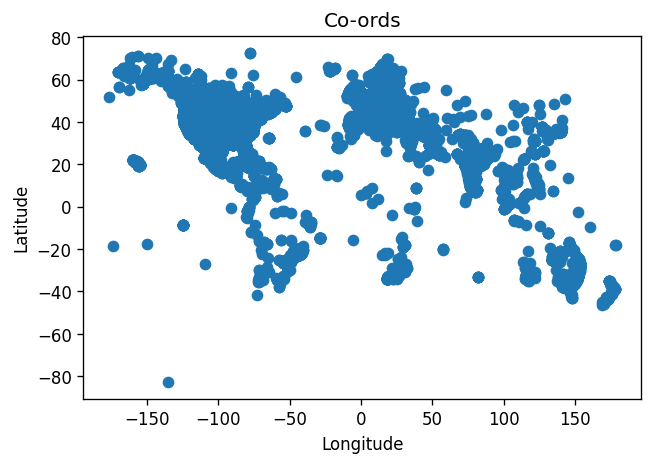

In [11]:
plt.figure(dpi=120)
x1 = ufo_cords['longitude']
x2 = ufo_cords['latitude']
plt.scatter(x1, x2)
plt.title("Co-ords")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [12]:
# create scaler object
scaler = StandardScaler()

# scale the data
X_scaled = scaler.fit_transform(ufo_cords)

In [13]:
print(X_scaled)

[[-0.78717219 -0.28133682]
 [-0.8348248  -0.29745896]
 [ 1.43994982  2.11240837]
 ...
 [ 0.01650357 -0.89456519]
 [ 0.07418529  0.23949655]
 [-0.23607724 -0.2696659 ]]


In [14]:
K=4

In [15]:
# Import KMeans model
from sklearn.cluster import KMeans
# Import time to measure algorithm runtime 
from time import time

In [16]:
## model and fit

#km = KMeans(n_clusters=K, random_state=42)
#km.fit(X_scaled)


In [17]:
# Manually implement the WCSS
def within_cluster_variation(df, label_col='label'):
    centroids = df.groupby(label_col).mean()
    out = 0
    for label, point in centroids.iterrows():
        df_features = df[df[label_col] == label].drop(label_col, axis=1)
        out += (df_features - point).pow(2).sum(axis=1).sum()
    return out

In [18]:
# let's try everything between 2 and 10 clusters
n_clusters = np.arange(2, 10)

# store errors for each value of k
errors = []

# for i between 2 and 20
for k in n_clusters:
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(X_scaled)

    # measure BCSS

    y_preds = km.predict(X_scaled)
    ufo_cords['cluster_label'] = y_preds
    errors.append(within_cluster_variation(ufo_cords,'cluster_label'))

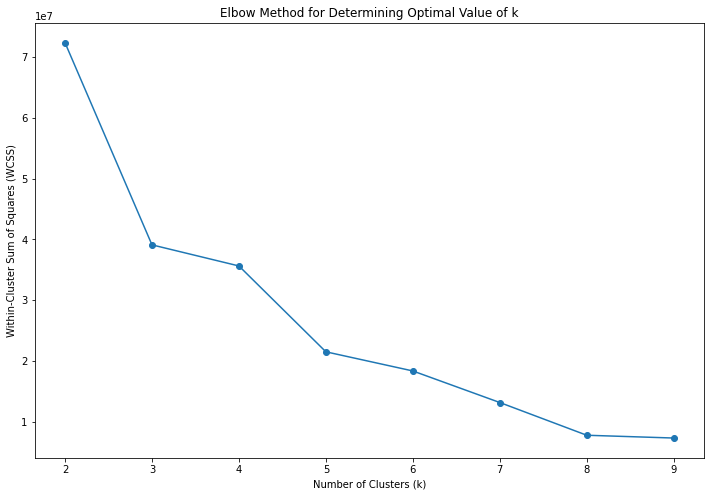

In [19]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors)
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)
plt.show()

In [20]:
# Between cluster variation
def between_cluster_variation(df, label_col='label'):
    centroids = df.groupby(label_col).mean()
    global_mean = df.drop(label_col, axis=1).mean()
    centroid_count = df.groupby(label_col).size()
    centroid_to_mean_dist = (centroids - global_mean).pow(2).sum(axis=1)
    return (centroid_count*centroid_to_mean_dist).sum()

In [21]:
# let's try everything between 2 and 15 clusters
n_clusters = np.arange(2, 15)

# store errors for each value of k
errors = []

# for i between 2 and 15
for k in n_clusters:
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(X_scaled)
    
    # measure BCSS

    y_preds = km.predict(X_scaled)
    ufo_cords['cluster_label'] = y_preds
    errors.append(between_cluster_variation(ufo_cords,'cluster_label'))

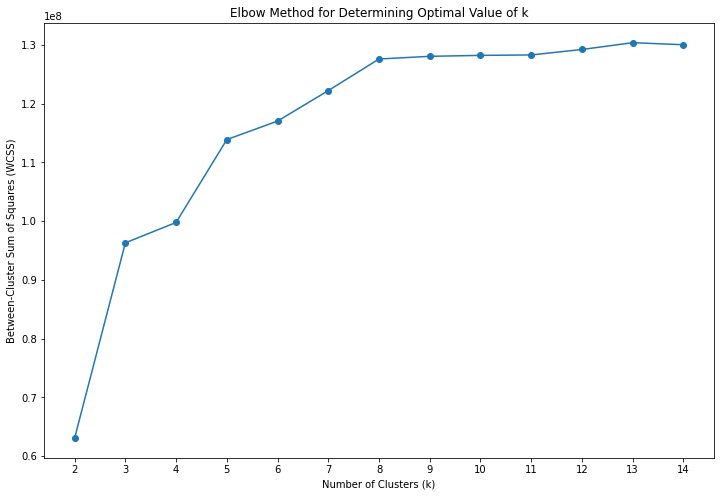

In [22]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Between-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors)
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)
plt.show()

In [23]:
## model the clusters

K = 5
# remember to set the random state for reproducibility
km = KMeans(n_clusters=K, verbose=0, random_state=42)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_scaled)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
done in 1.090s


In [24]:
# obtain cluster memberships for each item in the data
y_preds = km.predict(X_scaled)
ufo_cords['cluster_label'] = y_preds
centers = scaler.inverse_transform(km.cluster_centers_)

Text(0, 0.5, 'Feature 2')

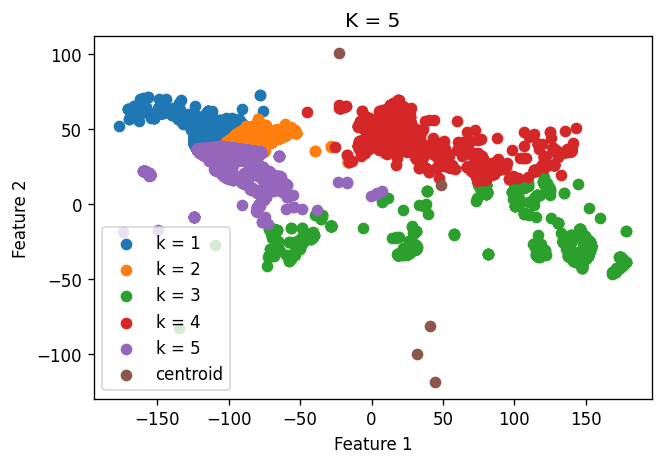

In [25]:
# visualise the clusters
plt.figure(dpi=120)
for k in range(K):
    x1 = ufo_cords[ufo_cords['cluster_label'] == k]['longitude']
    x2 = ufo_cords[ufo_cords['cluster_label'] == k]['latitude']
    plt.scatter(x1, x2, label="k = "+str(k+1))
    
# show cluster centroid locations
plt.scatter(centers[:,0],centers[:,1],label="centroid")


plt.legend()
plt.title("K = 5")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

In [26]:
ufo_cords.head()

,latitude,longitude,cluster_label
0,29.8831,-97.9411,4
1,29.3842,-98.5811,4
2,53.2000,-2.9167,3
3,28.9783,-96.6458,4
4,21.4181,-157.8036,4


In [27]:
ufo_cords.groupby('cluster_label').agg('median').T

cluster_label,0,1,2,3,4
latitude,45.2944,41.1306,-29.8587,51.6333,33.4269
longitude,-121.8939,-80.6069,133.7751,-0.3500,-97.3961


In [28]:
km.labels_[:100]

array([4, 4, 3, 4, 4, 1, 3, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 4, 1, 3, 1,
       4, 0, 3, 4, 1, 1, 1, 0, 4, 1, 4, 4, 1, 2, 4, 1, 1, 3, 1, 1, 1, 0,
       0, 4, 0, 1, 4, 1, 1, 4, 4, 1, 4, 3, 1, 1, 4, 1, 4, 1, 1, 0, 1, 2,
       4, 1, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 0, 1, 1, 4, 0, 1, 4, 4, 0, 0,
       0, 1, 4, 0, 1, 1, 4, 1, 1, 1, 1, 1], dtype=int32)

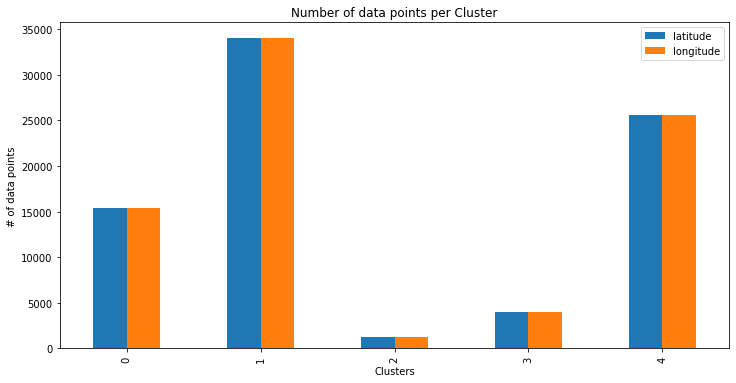

In [29]:
ufo_cords.groupby(
    'cluster_label').count().reset_index().plot(kind='bar', 
                                              x='cluster_label', 
                                              figsize=(12,6), 
                                              title='Number of data points per Cluster')
plt.xlabel("Clusters")
plt.ylabel("# of data points")
plt.show()

1    42.394065
4    31.892646
0    19.103222
3     4.984315
2     1.625753
Name: cluster_label, dtype: float64


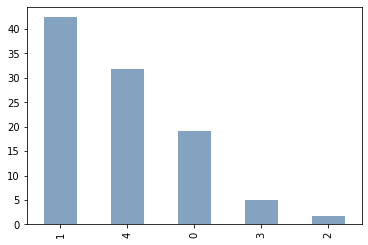

In [30]:
counts = ufo_cords['cluster_label'].value_counts()

total = len(ufo_cords['cluster_label'])

frequency = counts/total*100

frequency.plot(kind = 'bar',color=(0.2, 0.4, 0.6, 0.6))

print(frequency)


In [31]:
#world = gpd.read_file('https://raw.githubusercontent.com/st-reid/temp/main/worldmap.json')

In [32]:
## plot a dendogram

from scipy.cluster.hierarchy import ward, dendrogram
import scipy.cluster.hierarchy as sch

In [33]:
#select first 100 rows

ufo_100 = ufo_cords.head(100)

In [34]:
ufo_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   latitude       100 non-null    float64
 1   longitude      100 non-null    float64
 2   cluster_label  100 non-null    int32  
dtypes: float64(2), int32(1)
memory usage: 2.1 KB


In [35]:
# create scaler object
scaler = StandardScaler()

# scale the data
X_scaled = scaler.fit_transform(ufo_100)

In [36]:
#

In [37]:
linkage_matrix = sch.linkage(X_scaled, method='average', metric='euclidean')

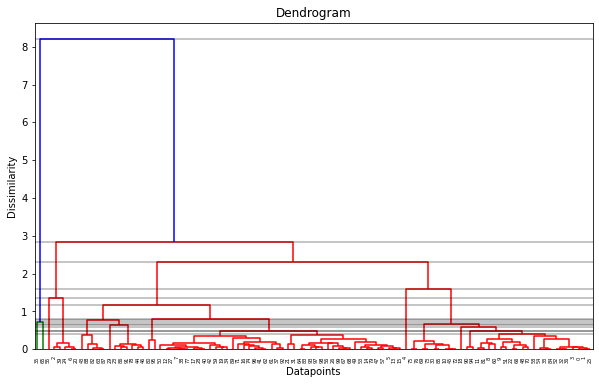

In [38]:
# Generate and plot dendrogram
plt.figure(figsize=(10,6))
dendrogram = sch.dendrogram(linkage_matrix)#, no_plot=True) # no_plot because we want to plot manually

# The linkage matrix also contains the disimilarity measures associated with each merge we've done
# We can use these to plot a few horizontal lines on the dendrogram
# that can help us find the right number of clusters better
z = linkage_matrix[:,2]

for i in range(1,16):
    rng = [z[-i],z[-i]]
    dom = [0,40000]
    plt.plot(dom,rng,'black', alpha=0.3)

plt.title('Dendrogram')
plt.xlabel('Datapoints')
plt.ylabel('Dissimilarity')

plt.show()

In [20]:
### dendogram of the years
## use the co-ords only
cols = ['latitude','longitude','city','state','country','shape','duration_(seconds)','duration_(hours/min)','comments','date_posted']

ufo_years = ufo_df2.drop(cols, inplace=False, axis=1)

ufo_years.head(5)
scaler = StandardScaler()

# scale the data
X_scaledy = scaler.fit_transform(ufo_years)
#

In [ ]:
linkage_matrix = sch.linkage(X_scaledy, method='average', metric='euclidean')

In [ ]:
# Generate and plot dendrogram
plt.figure(figsize=(10,6))
dendrogram = sch.dendrogram(linkage_matrix)#, no_plot=True) # no_plot because we want to plot manually

# The linkage matrix also contains the disimilarity measures associated with each merge we've done
# We can use these to plot a few horizontal lines on the dendrogram
# that can help us find the right number of clusters better
z = linkage_matrix[:,2]

for i in range(1,16):
    rng = [z[-i],z[-i]]
    dom = [0,40000]
    plt.plot(dom,rng,'black', alpha=0.3)

plt.title('Dendrogram')
plt.xlabel('Datapoints')
plt.ylabel('Dissimilarity')

plt.show()

In [40]:
### check the stop words

cols = ['latitude','longitude','datetime','city','state','country','shape','duration_(seconds)','duration_(hours/min)','date_posted']

ufo_comment = ufo_df2.drop(cols, inplace=False, axis=1)

ufo_comment.head()


,comments
0,This event took place in early fall around 194...
1,1949 Lackland AFB&#44 TX. Lights racing acros...
2,Green/Orange circular disc over Chester&#44 En...
3,My older brother and twin sister were leaving ...
4,AS a Marine 1st Lt. flying an FJ4B fighter/att...


### Question 8


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [44]:
ufo_comment['comments'] = ufo_comment['comments'].fillna('')

In [45]:
vectorizer = TfidfVectorizer(stop_words='english')

X_vectorizedc = vectorizer.fit_transform(ufo_comment['comments'])

In [48]:
feature_names = vectorizer.get_feature_names()

dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

NameError: ignored

### Question 9


In [49]:
##Question 9

vectorizer = TfidfVectorizer(max_features=20, stop_words='english')


X_vectorizedc2 = vectorizer.fit_transform(ufo_comment['comments'])

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10,random_state=1)

In [54]:
prin_comp = pca.fit_transform(X_vectorizedc2)

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)

pca_df["comments"] = ufo_comment["comments"]

TypeError: ignored

In [ ]:
clf = TruncatedSVD(n_compo)